In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

In [8]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = load_dataset()

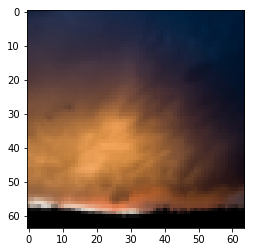

In [9]:
plt.imshow(train_set_x_orig[0])

In [10]:
# index = 25
# plt.imshow(train_set_x_orig[index])
# print('y='+ str(train_set_y[0][index])+', it is a '+classes[train_set_y[0][index]].decode("utf-8")+" picture")

In [11]:
m_train = train_set_y.shape[1]  # y是二维数组，求训练集数组y的列数，也就是图片的数目
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]  # 图片的长宽

# print ("Number of training examples: m_train = " + str(m_train))
# print ("Number of testing examples: m_test = " + str(m_test))
# print ("Height/Width of each image: num_px = " + str(num_px))
# print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
# print ("train_set_x shape: " + str(train_set_x_orig.shape))
# print ("train_set_y shape: " + str(train_set_y.shape))
# print ("test_set_x shape: " + str(test_set_x_orig.shape))
# print ("test_set_y shape: " + str(test_set_y.shape))

In [12]:
# 每一张图片转换为一个列向量
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T  # 图片向量
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T  
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
# print ("sanity check after reshaping: " + str(train_set_x_flatten[0:100,0]))
# print (train_set_x_orig[0][0])

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [13]:
# 数据集标准化
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

In [14]:
def sigmoid(z):
    """
    参数：
        z  - 任何大小的标量或numpy数组。

    返回：
        s  -  sigmoid（z）
    """
    s = 1 / (1 + np.exp(-z))
    return s

In [15]:
def initialize_with_zeros(dim):
    """列向量"""
    w = np.zeros(shape=(dim,1))
    b = 0
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))    
    return w,b

In [16]:
# 我们现在要实现一个计算成本函数及其渐变的函数propagate（）。

In [17]:
def propagate(w, b, X, Y):
    """
    实现前向和后向传播的成本函数及其梯度。
    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 矩阵类型为（num_px * num_px * 3，训练数量）
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据数量)

    返回：
        cost- 逻辑回归的负对数似然成本
        dw  - 相对于w的损失梯度，因此与w相同的形状
        db  - 相对于b的损失梯度，因此与b的形状相同
    """
    m = X.shape[1]  # 209

    #正向传播
    A = sigmoid(np.dot(w.T,X) + b) # w定义为列向量，此处要转置
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A))) #计算成本，* 为对应元素相乘

    #反向传播
    dw = (1 / m) * np.dot(X, (A - Y).T) #请参考视频中的偏导公式。
    db = (1 / m) * np.sum(A - Y) #请参考视频中的偏导公式。

    #使用断言确保我的数据是正确的
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    #创建一个字典，把dw和db保存起来。
    grads = {
                "dw": dw,
                "db": db
             }
    return (grads , cost)

In [22]:
def propation(w, b, X, Y,):
    Z = np.dot(w.T, X) + b  # row vector
    print(Z.shape)
    A = sigmoid(Z)
    dZ = A - Y
    dW = (1/209) * np.dot(X, dZ.T)
    db = (1/209) * np.sum(dZ)
    lost = (-1/209) * np.sum(Y*np.log(A)+(1-Y)*np.log(1 - A))
    cost = (- 1 /209) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
    print(lost, cost)
    step = dict()
    step['dw'] = dW
    step['db'] = db
    return step, lost

X,y = train_set_x_flatten, train_set_y
w, b = initialize_with_zeros(X.shape[0])
propation(w, b, X, y)

(1, 209)
0.69314718056 0.69314718056


({'db': 0.15550239234449761, 'dw': array([[ 12.03827751],
         [ 16.0645933 ],
         [ 12.55502392],
         ..., 
         [ 12.94019139],
         [ 15.84210526],
         [  8.27511962]])}, 0.69314718055994529)

In [21]:
# 反向传播

In [46]:
def optimize(w , b , X , Y , num_iterations , learning_rate , print_cost = False):
    """
    此函数通过运行梯度下降算法来优化w和b

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数组。
        Y  - 真正的“标签”矢量（如果非猫则为0，如果是猫则为1），矩阵维度为(1,训练数据的数量)
        num_iterations  - 优化循环的迭代次数
        learning_rate  - 梯度下降更新规则的学习率
        print_cost  - 每100步打印一次损失值

    返回：
        params  - 包含权重w和偏差b的字典
        grads  - 包含权重和偏差相对于成本函数的梯度的字典
        成本 - 优化期间计算的所有成本列表，将用于绘制学习曲线。

    提示：
    我们需要写下两个步骤并遍历它们：
        1）计算当前参数的成本和梯度，使用propagate（）。
        2）使用w和b的梯度下降法则更新参数。
    """

    costs = []

    for i in range(num_iterations):

        grads, cost = propagate(w, b, X, Y)

        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        #记录成本
        if i % 100 == 0:
            costs.append(cost)
        #打印成本数据
        if (print_cost) and (i % 100 == 0):
            print("迭代的次数: %i ， 误差值： %f" % (i,cost))

    params  = {
                "w" : w,
                "b" : b }
    grads = {
            "dw": dw,
            "db": db } 
    return (params , grads , costs)

In [47]:
# 预测函数

In [69]:
def predict(w , b , X ):
    """
    使用学习逻辑回归参数logistic （w，b）预测标签是0还是1，

    参数：
        w  - 权重，大小不等的数组（num_px * num_px * 3，1）
        b  - 偏差，一个标量
        X  - 维度为（num_px * num_px * 3，训练数据的数量）的数据

    返回：
        Y_prediction  - 包含X中所有图片的所有预测【0 | 1】的一个numpy数组（向量）

    """

    m  = X.shape[1] #图片的数量   X:12288*50
    Y_prediction = np.zeros((1,m)) 
    w = w.reshape(X.shape[0],1)

    #计预测猫在图片中出现的概率
    A = sigmoid(np.dot(w.T , X) + b)  # 用学习到的参数来计算预测值
    for i in range(A.shape[1]):
        #将概率a [0，i]转换为实际预测p [0，i]
        Y_prediction[0,i] = 1 if A[0,i] > 0.5 else 0
    #使用断言
    assert(Y_prediction.shape == (1,m))

    return Y_prediction

In [70]:
# 训练模型

In [71]:
def model(X_train , Y_train , X_test , Y_test , num_iterations = 2000 , learning_rate = 0.5 , print_cost = False):
    """
    通过调用之前实现的函数来构建逻辑回归模型

    参数：
        X_train  - numpy的数组,维度为（num_px * num_px * 3，m_train）的训练集
        Y_train  - numpy的数组,维度为（1，m_train）（矢量）的训练标签集
        X_test   - numpy的数组,维度为（num_px * num_px * 3，m_test）的测试集
        Y_test   - numpy的数组,维度为（1，m_test）的（向量）的测试标签集
        num_iterations  - 表示用于优化参数的迭代次数的超参数
        learning_rate  - 表示optimize（）更新规则中使用的学习速率的超参数
        print_cost  - 设置为true以每100次迭代打印成本

    返回：
        d  - 包含有关模型信息的字典。
    """
    w , b = initialize_with_zeros(X_train.shape[0])

    parameters , grads , costs = optimize(w , b , X_train , Y_train,num_iterations , learning_rate , print_cost)  # 打印迭代次数和误差值

    #从字典“参数”中检索参数w和b
    w , b = parameters["w"] , parameters["b"]

    #预测测试/训练集的例子
    Y_prediction_test = predict(w , b, X_test)
    Y_prediction_train = predict(w , b, X_train)

    #打印训练后的准确性
    print("训练集准确性："  , format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100) ,"%")
    print("测试集准确性："  , format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100) ,"%")

    d = {
            "costs" : costs,
            "Y_prediction_test" : Y_prediction_test,
            "Y_prediciton_train" : Y_prediction_train,
            "w" : w,
            "b" : b,
            "learning_rate" : learning_rate,
            "num_iterations" : num_iterations }
    return d

In [77]:
print("====================测试model====================")     
#这里加载的是真实的数据，请参见上面的代码部分。
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1000, learning_rate = 0.005, print_cost = True)
print(d)

====================测试model====================
迭代的次数: 0 ， 误差值： 0.693147
迭代的次数: 100 ， 误差值： 0.584508
迭代的次数: 200 ， 误差值： 0.466949
迭代的次数: 300 ， 误差值： 0.376007
迭代的次数: 400 ， 误差值： 0.331463
迭代的次数: 500 ， 误差值： 0.303273
迭代的次数: 600 ， 误差值： 0.279880
迭代的次数: 700 ， 误差值： 0.260042
迭代的次数: 800 ， 误差值： 0.242941
迭代的次数: 900 ， 误差值： 0.228004
训练集准确性： 96.65071770334929 %
测试集准确性： 72.0 %
{'costs': [0.69314718055994529, 0.58450836369930859, 0.46694904094655476, 0.37600686694802077, 0.33146328932825131, 0.30327306747438293, 0.27987958658260481, 0.26004213692587574, 0.24294068467796623, 0.22800422256726066], 'Y_prediction_test': array([[ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,
         1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,
         1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
         0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.]]), 'Y_prediciton_train': array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         1.,  1., 

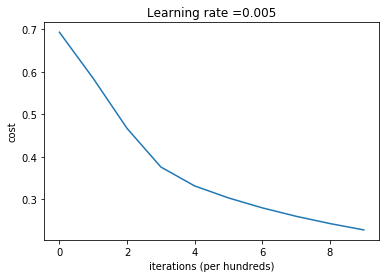

In [78]:
#绘制图
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
训练集准确性： 99.52153110047847 %
测试集准确性： 68.0 %

-------------------------------------------------------

learning rate is: 0.001
训练集准确性： 88.99521531100478 %
测试集准确性： 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
训练集准确性： 68.42105263157895 %
测试集准确性： 36.0 %

-------------------------------------------------------



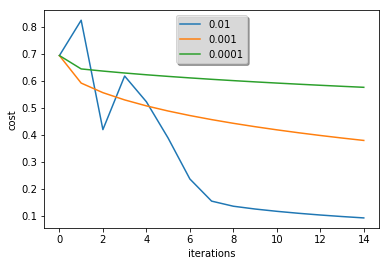

In [79]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()